In [2]:
from sae import Sae, SaeConfig
from scipy.optimize import linear_sum_assignment
import numpy as np
from tqdm import tqdm
from argparse import ArgumentParser
import torch
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_sae(dir, hookpoint, device):
    if "mnt" in dir:
        return Sae.load_from_disk(dir+"/"+hookpoint, device=device)
    else:
        return Sae.load_from_hub(dir, hookpoint=hookpoint, device=device)


## 32k

In [348]:
sae_dir = "EleutherAI/sae-pythia-160m-32k"
sae_2_seed_dir = "/mnt/ssd-1/nora/sae/k32-sae-mlp-32k-seed2"


In [349]:
sae = load_sae(sae_dir, "layers.6.mlp", "cuda:6")
sae_2_seed = load_sae(sae_2_seed_dir, "layers.6.mlp", "cuda:6")



Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


In [350]:
sae_2_seed_weight = sae_2_seed.W_dec.data / sae_2_seed.W_dec.data.norm(dim=1, keepdim=True)
sae_weight = sae.W_dec.data / sae.W_dec.data.norm(dim=1, keepdim=True)
sae_encoder_weight = sae.encoder.weight / sae.encoder.weight.norm(dim=1, keepdim=True)
sae_2_seed_encoder_weight = sae_2_seed.encoder.weight / sae_2_seed.encoder.weight.norm(dim=1, keepdim=True)

cost_dec = sae_weight @ sae_2_seed_weight.T
cost_enc = sae_encoder_weight @ sae_2_seed_encoder_weight.T
cost_dec = cost_dec.cpu().detach()
cost_enc = cost_enc.cpu().detach()

In [351]:
row_ind_dec,col_ind_dec = pickle.load(open("alignment/indices_decoder_32k_mlp.pkl","rb"))[0]["SAE 2"]
row_ind_enc,col_ind_enc = pickle.load(open("alignment/indices_encoder_32k_mlp.pkl","rb"))[0]["SAE 2"]



In [352]:
equal = col_ind_enc == col_ind_dec
count_equal = sum(equal)
print("Fraction of features aligned:",count_equal/len(col_ind_enc))
cost_higher_50 = cost_dec.numpy()[row_ind_dec,col_ind_dec] > 0.7
count_higher_50 = sum(cost_higher_50)
print("Fraction of features aligned with decoder > 0.5:",count_higher_50/len(col_ind_enc))


Fraction of features aligned: 0.792938232421875
Fraction of features aligned with decoder > 0.5: 0.532623291015625


Text(0, 0.5, 'Number of latents')

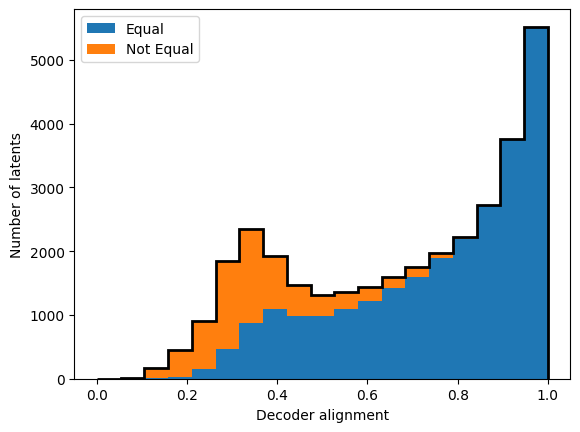

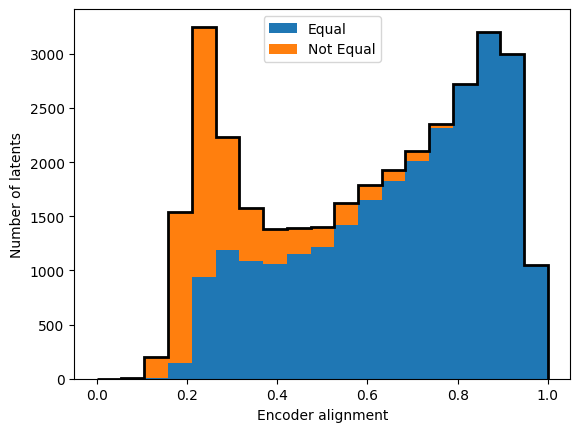

In [353]:
aligned_cost_dec_equal = cost_dec[row_ind_dec,col_ind_dec][equal]
aligned_cost_dec_not_equal = cost_dec[row_ind_dec,col_ind_dec][~equal]

plt.figure()
plt.hist([aligned_cost_dec_equal,aligned_cost_dec_not_equal],bins=np.linspace(0,1,20),label=["Equal","Not Equal"],stacked=True)
plt.hist(cost_dec.numpy()[row_ind_dec,col_ind_dec],bins=np.linspace(0,1,20),fill=False,histtype="step",color="black",linewidth=2)
#plt.yscale("log")
plt.legend()
plt.xlabel("Decoder alignment")
plt.ylabel("Number of latents")

aligned_cost_enc_equal = cost_enc[row_ind_enc,col_ind_enc][equal]
aligned_cost_enc_not_equal = cost_enc[row_ind_enc,col_ind_enc][~equal]

plt.figure()
plt.hist([aligned_cost_enc_equal,aligned_cost_enc_not_equal],bins=np.linspace(0,1,20),label=["Equal","Not Equal"],stacked=True)
plt.hist(cost_enc.numpy()[row_ind_enc,col_ind_enc],bins=np.linspace(0,1,20),fill=False,histtype="step",color="black",linewidth=2)
#plt.yscale("log")
plt.legend()
plt.xlabel("Encoder alignment")
plt.ylabel("Number of latents")

/mnt/ssd-1/gpaulo/miniconda3/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


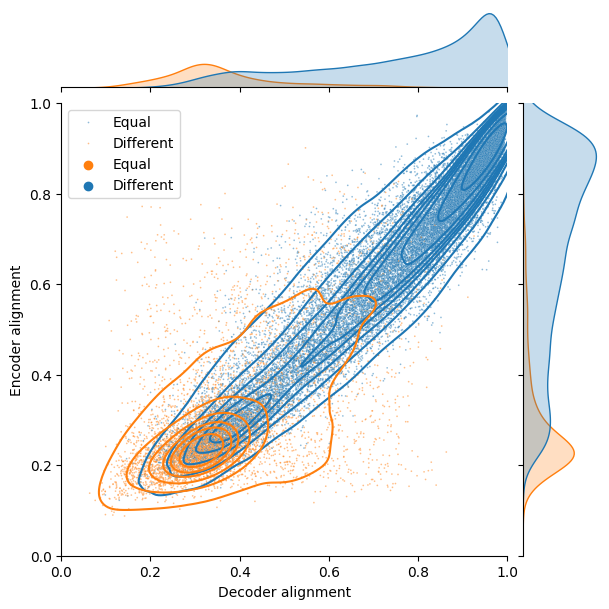

In [354]:
# have a list that says equal in the positions where equal is true and different in the positions where equal is false
equal_list = ["Equal" if e else "Different" for e in equal]


g = sns.jointplot(x=cost_dec.numpy()[row_ind_dec,col_ind_dec],y=cost_enc.numpy()[row_ind_enc,col_ind_enc],hue=equal_list,alpha=0.5,s=1.5)
g.plot_joint(sns.kdeplot,linewidth=2)
plt.scatter(-1,-1,color="C1",label="Equal")
plt.scatter(-1,-1,color="C0",label="Different")

plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.xlabel("Decoder alignment")
plt.ylabel("Encoder alignment")
plt.savefig("equal.svg")

### 3 comparison  

In [147]:
import os
import pickle

In [148]:
sae_3_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-seed3"

In [149]:
sae_3_seed = load_sae(sae_3_seed_dir, "layers.6.mlp", "cuda:6")

In [357]:
sae_decoder_weight = sae.W_dec.data / sae.W_dec.data.norm(dim=1, keepdim=True)
sae_2_seed_decoder_weight = sae_2_seed.W_dec.data / sae_2_seed.W_dec.data.norm(dim=1, keepdim=True)
sae_3_seed_decoder_weight = sae_3_seed.W_dec.data / sae_3_seed.W_dec.data.norm(dim=1, keepdim=True)

sae_encoder_weight = sae.encoder.weight / sae.encoder.weight.norm(dim=1, keepdim=True)
sae_2_seed_encoder_weight = sae_2_seed.encoder.weight / sae_2_seed.encoder.weight.norm(dim=1, keepdim=True)
sae_3_seed_encoder_weight = sae_3_seed.encoder.weight / sae_3_seed.encoder.weight.norm(dim=1, keepdim=True)


In [358]:

cost_23 = sae_2_seed_decoder_weight @ sae_3_seed_decoder_weight.T
cost_32 = sae_3_seed_decoder_weight @ sae_2_seed_decoder_weight.T

In [359]:
cost_12 = sae_decoder_weight @ sae_2_seed_decoder_weight.T
cost_12_enc = sae_encoder_weight @ sae_2_seed_encoder_weight.T
cost_13 = sae_decoder_weight @ sae_3_seed_decoder_weight.T
cost_13_enc = sae_encoder_weight @ sae_3_seed_encoder_weight.T
cost_23 = sae_2_seed_decoder_weight @ sae_3_seed_decoder_weight.T
# check if there is a file in alignment/indices
row_ind_dec_12,col_ind_dec_12 = pickle.load(open("alignment/indices_decoder_32k_mlp.pkl","rb"))[0]["SAE 2"]
row_ind_enc_12,col_ind_enc_12 = pickle.load(open("alignment/indices_encoder_32k_mlp.pkl","rb"))[0]["SAE 2"]
row_ind_dec_13,col_ind_dec_13 = pickle.load(open("indices_decoder_32k1-3.pkl","rb"))[0]["SAE 2"]
row_ind_enc_13,col_ind_enc_13 = pickle.load(open("indices_encoder_32k1-3.pkl","rb"))[0]["SAE 2"]
row_ind_dec_23,col_ind_dec_23 = pickle.load(open("indices_decoder_32k2-3.pkl","rb"))[0]["SAE 2"]
row_ind_enc_23,col_ind_enc_23 = pickle.load(open("indices_encoder_32k2-3.pkl","rb"))[0]["SAE 2"]
row_ind_dec_32,col_ind_dec_32 = pickle.load(open("indices_decoder_32k3-2.pkl","rb"))[0]["SAE 2"]
row_ind_enc_32,col_ind_enc_32 = pickle.load(open("indices_encoder_32k3-2.pkl","rb"))[0]["SAE 2"]

#row_ind12, col_ind12 = linear_sum_assignment(cost_12.cpu().numpy(), maximize=True)



In [360]:
cost_12 = cost_12.cpu().numpy()
cost_12_enc = cost_12_enc.cpu().detach().numpy()
cost_13 = cost_13.cpu().numpy()
cost_13_enc = cost_13_enc.cpu().detach().numpy()



In [361]:
mask_1_and_2 = cost_12[row_ind_dec_12, col_ind_dec_12] > 0.7
mask_1_and_2_alt = cost_12_enc[row_ind_enc_12, col_ind_enc_12] > 0.7
mask_1_and_2 = mask_1_and_2 & mask_1_and_2_alt
#mask_1_and_2 = col_ind_dec_12==col_ind_enc_12
mask_1_and_3 = cost_13[row_ind_dec_13, col_ind_dec_13] > 0.7
mask_1_and_3_alt = cost_13_enc[row_ind_enc_13, col_ind_enc_13] > 0.7
mask_1_and_3 = mask_1_and_3 & mask_1_and_3_alt
#mask_1_and_3 = col_ind_dec_13==col_ind_enc_13

#mask_2_and_3 = cost_23[row_ind_dec_23, col_ind_dec_23][col_ind_dec_12] > 0.8


In [362]:
import matplotlib_venn

In [363]:
sae_1_in_1_and_2 = set(row_ind_dec_12[mask_1_and_2])
sae_1_in_1_and_3 = set(row_ind_dec_13[mask_1_and_3])
sae_1_in_1_and_2_and_3 = sae_1_in_1_and_2 & sae_1_in_1_and_3
sae_1_just_in_1 = set(row_ind_dec_12)-sae_1_in_1_and_2-sae_1_in_1_and_3-sae_1_in_1_and_2_and_3
sae_1_just_in_1_and_2 =  sae_1_in_1_and_2 - sae_1_in_1_and_3 - sae_1_in_1_and_2_and_3
sae_1_just_in_1_and_3 =  sae_1_in_1_and_3 - sae_1_in_1_and_2 - sae_1_in_1_and_2_and_3
print(len(sae_1_just_in_1),len(sae_1_just_in_1_and_2),len(sae_1_just_in_1_and_3),len(sae_1_in_1_and_2_and_3))


15742 2915 3398 10713


In [364]:
labels = np.zeros(len(sae_1_just_in_1)+len(sae_1_just_in_1_and_2)+len(sae_1_just_in_1_and_3)+len(sae_1_in_1_and_2_and_3))
labels[list(sae_1_just_in_1)] = "1"
labels[list(sae_1_just_in_1_and_2)] = "2"
labels[list(sae_1_just_in_1_and_3)] = "3"
labels[list(sae_1_in_1_and_2_and_3)] = "4"


In [365]:
import plotly.graph_objects as go

In [366]:
fig = go.Figure(data=[go.Pie(labels=["SAE-1","SAE-1 and SAE-2","SAE-1 and SAE-3","All SAEs"],
                              values=[len(sae_1_just_in_1),len(sae_1_just_in_1_and_2),len(sae_1_just_in_1_and_3),len(sae_1_in_1_and_2_and_3)],
                              hole=0.5,
                              marker=dict(line=dict(color='black', width=2)))])
fig.update_layout(legend=dict(yanchor="middle",y=0.55,xanchor="center",x=0.7))
fig.show()


In [367]:
import blobfile
from safetensors.numpy import load_file

In [368]:
def load_locations(path):
    all_locations = []
    for file in blobfile.listdir(path):
        if file.endswith(".safetensors"):
            split_data = load_file(f"{path}/{file}")
            locations = torch.tensor(split_data["locations"].astype(np.int64))
            valid_range = file.split("_")[0]
            locations[:,2] = locations[:,2]+int(valid_range)
            all_locations.append(locations)
    return torch.cat(all_locations)

In [369]:
raw_features_sae_path = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/raw_features/pythia_pile/SAE/.gpt_neox.layers.6.mlp"
raw_features_sae2_path = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/raw_features/pythia_pile/SAE-2-seed/.gpt_neox.layers.6.mlp"

locations_sae = load_locations(raw_features_sae_path)
locations_sae2 = load_locations(raw_features_sae2_path)

print(locations_sae.shape)
print(locations_sae2.shape)

torch.Size([319815680, 3])
torch.Size([319815680, 3])


In [370]:
# count unique values
sorted_locations_sae = locations_sae[locations_sae[:,2].sort()[1]]
sorted_locations_sae2 = locations_sae2[locations_sae2[:,2].sort()[1]]

index_sae,counts_sae = torch.unique_consecutive(sorted_locations_sae[:,2],return_counts=True)
index_sae2,counts_sae2 = torch.unique_consecutive(sorted_locations_sae2[:,2],return_counts=True)

real_counts_sae = torch.zeros(32768,dtype = counts_sae.dtype)
real_counts_sae2 = torch.zeros(32768,dtype = counts_sae2.dtype)
real_counts_sae[index_sae] = counts_sae
real_counts_sae2[index_sae2] = counts_sae2

/tmp/ipykernel_768787/3421784970.py:48: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



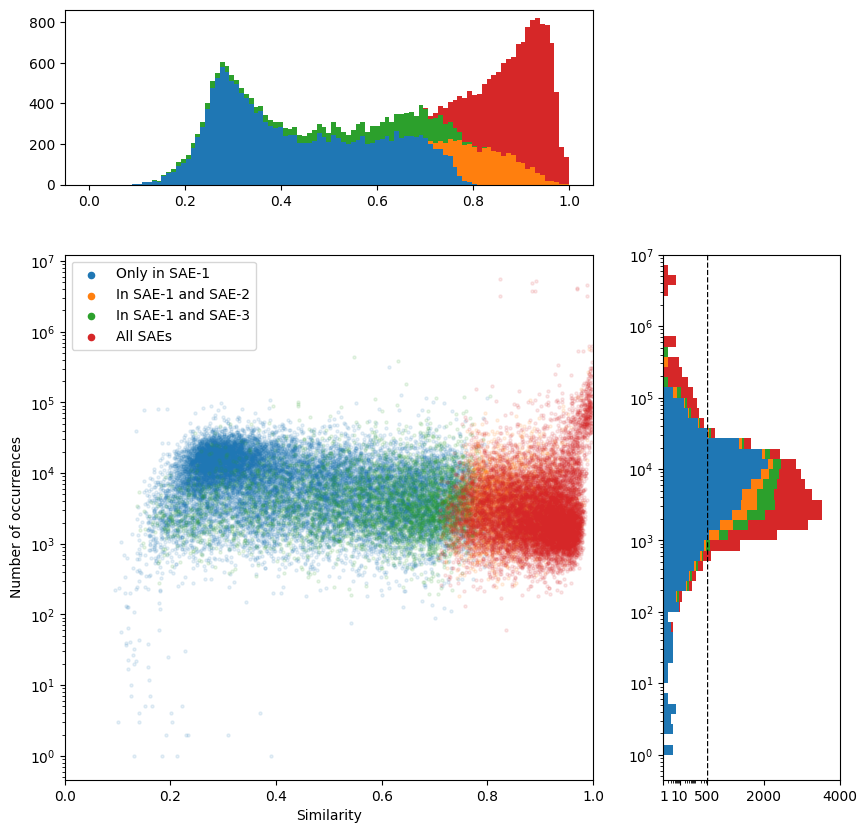

In [384]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and GridSpec
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3])

# Create the three subplots
ax_top = fig.add_subplot(gs[0, 0])    # Top histogram
ax_right = fig.add_subplot(gs[1, 1])  # Right histogram
ax_main = fig.add_subplot(gs[1, 0])   # Main scatter plot


# separate real_counts_sae into 4 groups
real_counts_sae_1 = real_counts_sae[labels == 1]
real_counts_sae_2 = real_counts_sae[labels == 2]
real_counts_sae_3 = real_counts_sae[labels == 3]
real_counts_sae_4 = real_counts_sae[labels == 4]


cost_12_1 = 0.5*(cost_12[row_ind_dec_12, col_ind_dec_12]+cost_12_enc[row_ind_enc_12, col_ind_enc_12])[labels == 1]
cost_12_2 = 0.5*(cost_12[row_ind_dec_12, col_ind_dec_12]+cost_12_enc[row_ind_enc_12, col_ind_enc_12])[labels == 2]
cost_12_3 = 0.5*(cost_12[row_ind_dec_12, col_ind_dec_12]+cost_12_enc[row_ind_enc_12, col_ind_enc_12])[labels == 3]
cost_12_4 = 0.5*(cost_12[row_ind_dec_12, col_ind_dec_12]+cost_12_enc[row_ind_enc_12, col_ind_enc_12])[labels == 4]


ax_main.scatter(cost_12_1,real_counts_sae_1.cpu().numpy(),s=5,alpha=0.1,c="C0")
ax_main.scatter(-1,-1,s=20,c="C0",label="Only in SAE-1")
ax_main.scatter(cost_12_2,real_counts_sae_2.cpu().numpy(),s=5,alpha=0.1,c="C1")
ax_main.scatter(-1,-1,s=20,c="C1",label="In SAE-1 and SAE-2")
ax_main.scatter(cost_12_3,real_counts_sae_3.cpu().numpy(),s=5,alpha=0.1,c="C2")
ax_main.scatter(-1,-1,s=20,c="C2",label="In SAE-1 and SAE-3")
ax_main.scatter(cost_12_4,real_counts_sae_4.cpu().numpy(),s=5,alpha=0.1,c="C3")
ax_main.scatter(-1,-1,s=20,c="C3",label="All SAEs")
ax_main.set_yscale("log")



ax_right.hist([real_counts_sae_1.cpu().numpy(),real_counts_sae_2.cpu().numpy(),real_counts_sae_3.cpu().numpy(),real_counts_sae_4.cpu().numpy()], bins=np.logspace(0,7,50), orientation='horizontal',color=["C0","C1","C2","C3"],histtype="barstacked")
ax_right.set_yscale("log")
ax_right.set_xlim(500,4000)
ax_right.set_xticks([2000,4000])
ax_right.set_xticklabels(["2000","4000"])
ax_right.set_ylim(0,10000000)
ax_right.plot([500,500],[0,100000000],color="black",linewidth=1,ls="--")
ax_right.spines["left"].set_visible(False)
ax_right.yaxis.set_ticks_position('right')
ax_right.yaxis.set_visible(False)

divider = make_axes_locatable(ax_right)
ax_lin = divider.append_axes("left", size="33%", pad=0,sharey=ax_right)
ax_lin.hist([real_counts_sae_1,real_counts_sae_2,real_counts_sae_3,real_counts_sae_4],bins=np.logspace(0,7,50),color=["C0","C1","C2","C3"],orientation="horizontal",histtype="barstacked")
ax_lin.set_xlim(1,500)
ax_lin.set_yscale("log")
ax_lin.set_xscale("log")
ax_lin.tick_params(axis='x', which='minor', bottom=True, top=False, labelbottom=False)
ax_lin.spines["right"].set_visible(False)
ax_lin.set_xticks([1,10,500])
ax_lin.set_xticklabels(["1","10","500"])

ax_main.set_ylabel("Number of occurrences")
ax_main.set_xlabel("Similarity")
ax_main.legend()
ax_main.set_xlim(0,1)

ax_top.hist([cost_12_1,cost_12_2,cost_12_3,cost_12_4],bins=np.linspace(0,1,100),color=["C0","C1","C2","C3"],histtype="barstacked")

plt.savefig("sae_overlap.png",dpi=300)

In [372]:
scores_32k = pd.read_csv("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/results/scores_layer6_recall_SAE.csv")
scores_32k_seed2 = pd.read_csv("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/results/scores_layer6_recall_SAE-2-seed.csv")

In [373]:
all_scores_seed1 = np.zeros(32768)
latents = scores_32k["feature"]
all_scores_seed1[latents.values] = scores_32k["balanced_accuracy"].values
all_other_scores = np.zeros(32768)
latents = scores_32k_seed2["feature"]
all_other_scores[latents.values] = scores_32k_seed2["balanced_accuracy"].values
all_other_scores = all_other_scores[col_ind_dec_12]

# where all_scores is 0 set all_other_scores to 0
#all_scores_seed1[all_other_scores == 0] = 0
# where all_other_scores is 0 set all_scores to 0
all_other_scores[all_scores_seed1 == 0] = 0

all_scores = (all_scores_seed1)


# #quantiles 
q25, q50, q75 = np.percentile(all_scores[all_scores > 0], [25, 50, 75])
print(q25,q50,q75)
low_scores = (all_scores < q25) & (all_scores > 0)
high_scores = all_scores > q75
average_scores = (all_scores >= q25) & (all_scores <= q75) & (all_scores > 0)
no_scores = all_scores == 0



0.62 0.7171786240269303 0.8043604039553965


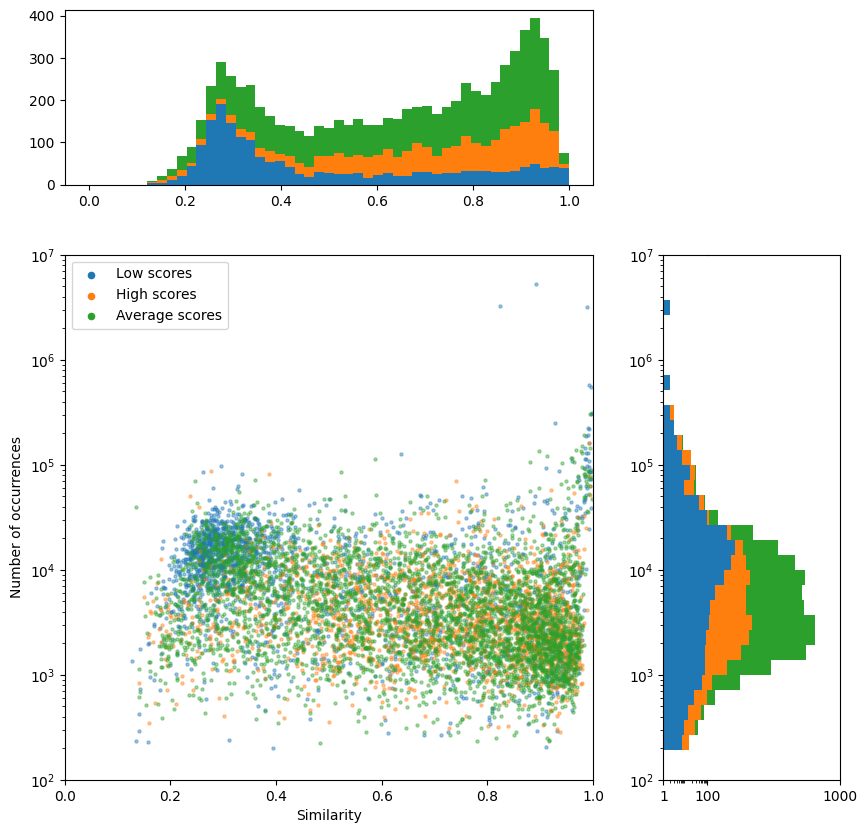

In [383]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and GridSpec
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3])

# Create the three subplots
ax_top = fig.add_subplot(gs[0, 0])    # Top histogram
ax_right = fig.add_subplot(gs[1, 1])  # Right histogram
ax_main = fig.add_subplot(gs[1, 0])   # Main scatter plot


# separate real_counts_sae into 4 groups
real_counts_sae_1 = real_counts_sae[low_scores]
real_counts_sae_2 = real_counts_sae[average_scores]
real_counts_sae_3 = real_counts_sae[high_scores]


cost_12_1 = 0.5*(cost_12[row_ind_dec_12, col_ind_dec_12]+cost_12_enc[row_ind_enc_12, col_ind_enc_12])[low_scores]
cost_12_2 = 0.5*(cost_12[row_ind_dec_12, col_ind_dec_12]+cost_12_enc[row_ind_enc_12, col_ind_enc_12])[average_scores]
cost_12_3 = 0.5*(cost_12[row_ind_dec_12, col_ind_dec_12]+cost_12_enc[row_ind_enc_12, col_ind_enc_12])[high_scores]


ax_main.scatter(cost_12_1,real_counts_sae_1.cpu().numpy(),s=5,alpha=0.4,c="C0")
ax_main.scatter(-1,-1,s=20,c="C0",label="Low scores")
ax_main.scatter(cost_12_3,real_counts_sae_3.cpu().numpy(),s=5,alpha=0.4,c="C1")
ax_main.scatter(-1,-1,s=20,c="C1",label="High scores")
ax_main.scatter(cost_12_2,real_counts_sae_2.cpu().numpy(),s=5,alpha=0.4,c="C2")
ax_main.scatter(-1,-1,s=20,c="C2",label="Average scores")

ax_main.set_yscale("log")



ax_right.hist([real_counts_sae_1.cpu().numpy(),real_counts_sae_3.cpu().numpy(),real_counts_sae_2.cpu().numpy()], bins=np.logspace(0,7,50), orientation='horizontal',color=["C0","C1","C2"],histtype="barstacked")
ax_right.set_yscale("log")
ax_right.set_xscale("linear")
ax_right.set_ylim(100,10000000)
ax_right.set_xlim(100,1000)
ax_right.set_xticks([1000])
ax_right.set_xticklabels(["1000"])
ax_right.spines["left"].set_visible(False)
ax_right.yaxis.set_ticks_position('right')
ax_right.yaxis.set_visible(False)

divider = make_axes_locatable(ax_right)
ax_lin = divider.append_axes("left", size="33%", pad=0,sharey=ax_right)
ax_lin.hist([real_counts_sae_1,real_counts_sae_2,real_counts_sae_3],bins=np.logspace(0,7,50),color=["C0","C1","C2"],orientation="horizontal",histtype="barstacked")
ax_lin.set_xlim(1,100)
ax_lin.set_yscale("log")
ax_lin.set_xscale("log")
ax_lin.tick_params(axis='x', which='minor', bottom=True, top=False, labelbottom=False)
ax_lin.spines["right"].set_visible(False)
ax_lin.set_xticks([1,100])
ax_lin.set_xticklabels(["1","100"])


#ax_right.set_xscale("symlog")

ax_main.set_ylabel("Number of occurrences")
ax_main.set_xlabel("Similarity")
ax_main.legend()
ax_main.set_xlim(0,1)
ax_main.set_ylim(100,10000000)

#separate cost_12 into 4 groups 

ax_top.hist([cost_12_1,cost_12_3,cost_12_2],bins=np.linspace(0,1,50),color=["C0","C1","C2"],histtype="barstacked")

plt.savefig("sae_scores.png",dpi=300)

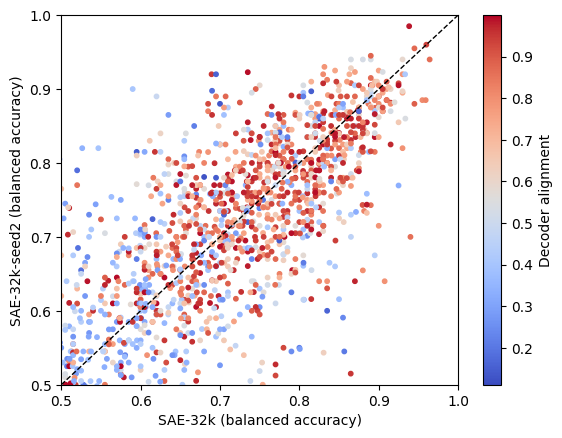

In [382]:
plt.scatter(all_scores_seed1[all_scores_seed1 > 0],all_other_scores[all_scores_seed1 > 0],c=cost_12[row_ind_dec_12,col_ind_dec_12][all_scores_seed1 > 0],s=10,cmap="coolwarm")
plt.plot([0.5,1],[0.5,1],color="black",linewidth=1,ls="--")
plt.ylim(0.5,1)
plt.xlim(0.5,1)
plt.xlabel("SAE-32k (balanced accuracy)")
plt.ylabel("SAE-32k-seed2 (balanced accuracy)")
plt.colorbar(label="Decoder alignment")
plt.savefig("sae_scores_scatter.png",dpi=300)

# Sizes

In [5]:
_,indices_dec_32 = pickle.load(open("alignment/indices_decoder_32.pkl","rb"))[0]["SAE 2"]
_,indices_enc_32 = pickle.load(open("alignment/indices_encoder_32.pkl","rb"))[0]["SAE 2"]
_,indices_dec_768 = pickle.load(open("alignment/indices_decoder_768.pkl","rb"))[0]["SAE 2"]
_,indices_enc_768 = pickle.load(open("alignment/indices_encoder_768.pkl","rb"))[0]["SAE 2"]
_,indices_dec_4k = pickle.load(open("alignment/indices_decoder_4k_mlp.pkl","rb"))[0]["SAE 2"]
_,indices_enc_4k = pickle.load(open("alignment/indices_encoder_4k.pkl","rb"))[0]["SAE 2"]
_,indices_dec_32k = pickle.load(open("alignment/indices_decoder_32k_mlp.pkl","rb"))[0]["SAE 2"]
_,indices_enc_32k = pickle.load(open("alignment/indices_encoder_32k_mlp.pkl","rb"))[0]["SAE 2"]
_,indices_dec_131k = pickle.load(open("alignment/indices_decoder_131k-mlp.pkl","rb"))[0]["SAE 2"]
_,indices_enc_131k = pickle.load(open("alignment/indices_encoder_131k-mlp.pkl","rb"))[0]["SAE 2"]


In [6]:

sae_32_seed1 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32", "layers.6.mlp", "cuda:6")
sae_32_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32-seed2", "layers.6.mlp", "cuda:6")

sae_768_seed1 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-768", "layers.6.mlp", "cuda:6")
sae_768_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-768-seed2", "layers.6.mlp", "cuda:6")

sae_4k_seed1 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-4k", "layers.6.mlp", "cuda:6")
sae_4k_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-4k-seed2", "layers.6.mlp", "cuda:6")

sae_32k_seed1 = load_sae(sae_dir, "layers.6.mlp", "cuda:6")
sae_32k_seed2 = load_sae(sae_2_seed_dir, "layers.6.mlp", "cuda:6")

sae_131k_seed1 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-131k", "layers.6.mlp", "cuda:7")
sae_131k_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-131k-seed2", "layers.6.mlp", "cuda:7")


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


In [7]:
cost_32_dec = sae_32_seed1.W_dec.data @ sae_32_seed2.W_dec.data.T
cost_32_enc = (sae_32_seed1.encoder.weight/sae_32_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_32_seed2.encoder.weight/sae_32_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_768_dec = sae_768_seed1.W_dec.data @ sae_768_seed2.W_dec.data.T
cost_768_enc = (sae_768_seed1.encoder.weight/sae_768_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_768_seed2.encoder.weight/sae_768_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_4k_dec = sae_4k_seed1.W_dec.data @ sae_4k_seed2.W_dec.data.T
cost_4k_enc = (sae_4k_seed1.encoder.weight/sae_4k_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_4k_seed2.encoder.weight/sae_4k_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_32k_dec = sae_32k_seed1.W_dec.data @ sae_32k_seed2.W_dec.data.T
cost_32k_enc = (sae_32k_seed1.encoder.weight/sae_32k_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_32k_seed2.encoder.weight/sae_32k_seed2.encoder.weight.norm(dim=1,keepdim=True)).T


cost_32_dec = cost_32_dec.cpu().detach().numpy()
cost_768_dec = cost_768_dec.cpu().detach().numpy()
cost_4k_dec = cost_4k_dec.cpu().detach().numpy()
cost_32k_dec = cost_32k_dec.cpu().detach().numpy()

cost_32_enc = cost_32_enc.cpu().detach().numpy()
cost_768_enc = cost_768_enc.cpu().detach().numpy()
cost_4k_enc = cost_4k_enc.cpu().detach().numpy()
cost_32k_enc = cost_32k_enc.cpu().detach().numpy()



In [8]:
batch_size = 4096  # Adjust batch size based on available memory
n_batches = (sae_131k_seed1.W_dec.data.shape[0] + batch_size - 1) // batch_size
cost_131k_dec = torch.zeros(sae_131k_seed1.W_dec.data.shape[0], sae_131k_seed2.W_dec.data.shape[0], device="cpu")

for i in tqdm(range(n_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, sae_131k_seed1.W_dec.data.shape[0])
    value = sae_131k_seed1.W_dec.data[start_idx:end_idx] @ sae_131k_seed2.W_dec.data.T
    cost_131k_dec[start_idx:end_idx] = value.cpu()


    

100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


In [9]:
cost_131k_enc = torch.zeros(sae_131k_seed1.encoder.weight.shape[0], sae_131k_seed2.encoder.weight.shape[0], device="cpu")
sae_131k_seed1_encoder_normed = sae_131k_seed1.encoder.weight/sae_131k_seed1.encoder.weight.norm(dim=1,keepdim=True)
sae_131k_seed2_encoder_normed = sae_131k_seed2.encoder.weight/sae_131k_seed2.encoder.weight.norm(dim=1,keepdim=True)
for i in tqdm(range(n_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, sae_131k_seed1.encoder.weight.shape[0])
    value = sae_131k_seed1_encoder_normed[start_idx:end_idx] @ sae_131k_seed2_encoder_normed.T
    cost_131k_enc[start_idx:end_idx] = value.cpu()

100%|██████████| 32/32 [00:30<00:00,  1.03it/s]


In [10]:
cost_131k_dec = cost_131k_dec.cpu().detach().numpy()
cost_131k_enc = cost_131k_enc.cpu().detach().numpy()


In [11]:
_,indices_dec_768 = linear_sum_assignment(cost_768_dec,maximize=True)
_,indices_enc_768 = linear_sum_assignment(cost_768_enc,maximize=True)   
_,indices_dec_32 = linear_sum_assignment(cost_32_dec,maximize=True)
_,indices_enc_32 = linear_sum_assignment(cost_32_enc,maximize=True)

In [12]:
_,indices_dec_4k = linear_sum_assignment(cost_4k_dec,maximize=True)
_,indices_enc_4k = linear_sum_assignment(cost_4k_enc,maximize=True)


In [388]:
mask_32 = cost_32_dec[np.arange(len(indices_dec_32)),indices_dec_32] > 0.7
other_mask = cost_32_enc[np.arange(len(indices_enc_32)),indices_enc_32] > 0.7
max_cosine_32 = np.max(cost_32_dec,axis=1) > 0.7
threshold_32 = sum(mask_32 & other_mask)/len(indices_dec_32)
equal_32 = sum(indices_dec_32 == indices_enc_32)/len(indices_dec_32)
print(threshold_32)
print(equal_32)
print(sum(max_cosine_32)/len(max_cosine_32))

0.8125
1.0
0.84375


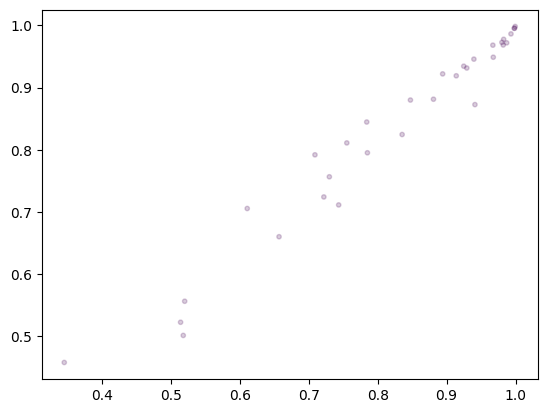

In [14]:
plt.scatter(cost_32_dec[np.arange(len(indices_dec_32)),indices_dec_32],cost_32_enc[np.arange(len(indices_enc_32)),indices_enc_32],s=10,alpha=0.2,c=indices_dec_32==indices_enc_32)

In [389]:
mask_768 = cost_768_dec[np.arange(len(indices_dec_768)),indices_dec_768] > 0.7
other_mask_768 = cost_768_enc[np.arange(len(indices_enc_768)),indices_enc_768] > 0.7
threshold_768 = sum(mask_768 & other_mask_768)/len(indices_dec_768)
equal_768 = sum(indices_dec_768==indices_enc_768)/len(indices_dec_768)
max_cosine_768 = np.max(cost_768_dec,axis=1) > 0.7
print(threshold_768)
print(equal_768)
print(sum(max_cosine_768)/len(max_cosine_768))

0.78515625
0.94921875
0.8203125


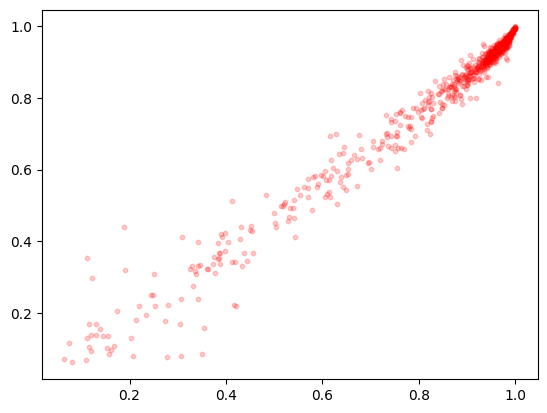

In [16]:
plt.scatter(cost_768_dec[np.arange(len(indices_dec_768)),indices_dec_768],cost_768_enc[np.arange(len(indices_enc_768)),indices_enc_768],s=10,alpha=0.2,color="red")

In [390]:
mask_4k = cost_4k_dec[np.arange(len(indices_dec_4k)),indices_dec_4k] > 0.7
other_mask_4k = cost_4k_enc[np.arange(len(indices_enc_4k)),indices_enc_4k] > 0.7
threshold_4k = sum(mask_4k & other_mask_4k)/len(indices_dec_4k)
equal_4k = sum(indices_dec_4k==indices_enc_4k)/len(indices_dec_4k)
print(threshold_4k)
print(equal_4k)
max_cosine_4k = np.max(cost_4k_dec,axis=1) > 0.7
print(sum(max_cosine_4k)/len(max_cosine_4k))

0.69564152791381
0.9162585700293829
0.7690989226248776


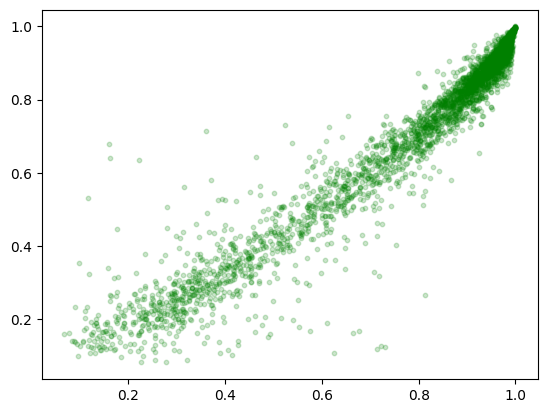

In [18]:
plt.scatter(cost_4k_dec[np.arange(len(indices_dec_4k)),indices_dec_4k],cost_4k_enc[np.arange(len(indices_enc_4k)),indices_enc_4k],s=10,alpha=0.2,color="green")


In [391]:
mask_32k = cost_32k_dec[np.arange(len(indices_dec_32k)),indices_dec_32k] > 0.7
other_mask_32k = cost_32k_enc[np.arange(len(indices_enc_32k)),indices_enc_32k] > 0.7
threshold_32k = sum(mask_32k & other_mask_32k)/len(indices_dec_32k)
equal_32k = sum(indices_dec_32k==indices_enc_32k)/len(indices_dec_32k)
print(threshold_32k)
print(equal_32k)
max_cosine_32k = np.max(cost_32k_dec,axis=1) > 0.7
print(sum(max_cosine_32k)/len(max_cosine_32k))

0.4158935546875
0.792938232421875
0.5496826171875


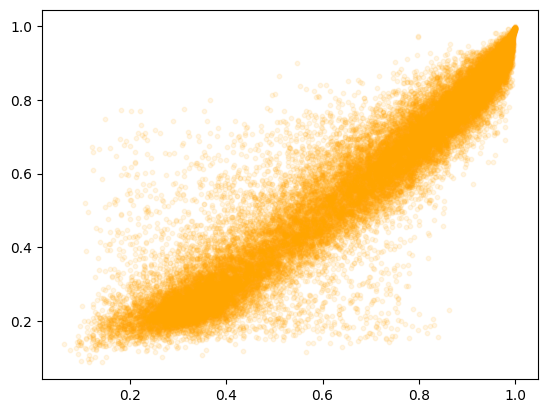

In [20]:
plt.scatter(cost_32k_dec[np.arange(len(indices_dec_32k)),indices_dec_32k],cost_32k_enc[np.arange(len(indices_enc_32k)),indices_enc_32k],s=10,alpha=0.1,color="orange")

In [392]:
mask_131k = cost_131k_dec[np.arange(len(indices_dec_131k)),indices_dec_131k] > 0.7
other_mask_131k = cost_131k_enc[np.arange(len(indices_enc_131k)),indices_enc_131k] > 0.7
threshold_131k = sum(mask_131k & other_mask_131k)/len(indices_dec_131k)
equal_131k = sum(indices_dec_131k==indices_enc_131k)/len(indices_dec_131k)
print(threshold_131k)
print(equal_131k)
max_cosine_131k = np.max(cost_131k_dec,axis=1) > 0.7
print(sum(max_cosine_131k)/len(max_cosine_131k))

0.27581024169921875
0.7018966674804688
0.3983612060546875


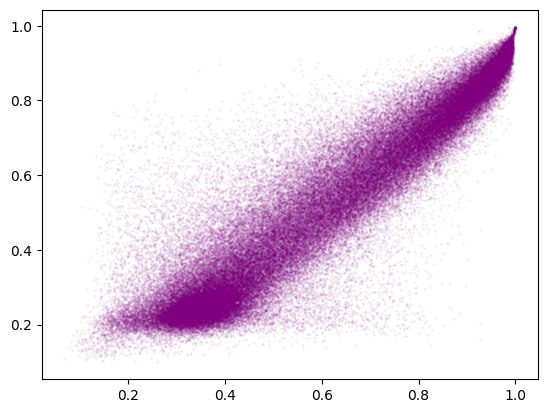

In [22]:
plt.scatter(cost_131k_dec[np.arange(len(indices_dec_131k)),indices_dec_131k],cost_131k_enc[np.arange(len(indices_enc_131k)),indices_enc_131k],s=1,alpha=0.05,color="purple")


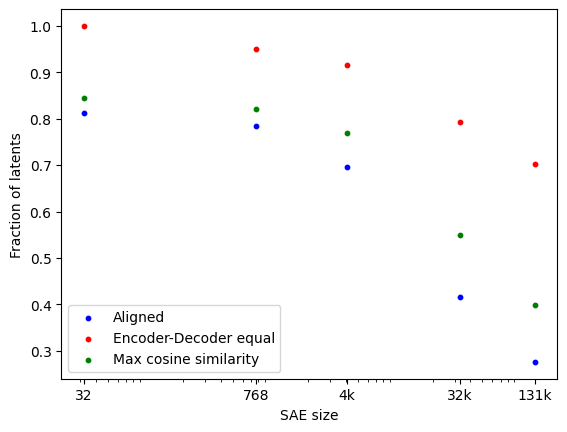

In [393]:
thresholds = [threshold_32,threshold_768,threshold_4k,threshold_32k,threshold_131k]
equal = [equal_32,equal_768,equal_4k,equal_32k,equal_131k]
max_cosines = [sum(max_cosine_32)/len(max_cosine_32),sum(max_cosine_768)/len(max_cosine_768),sum(max_cosine_4k)/len(max_cosine_4k),sum(max_cosine_32k)/len(max_cosine_32k),sum(max_cosine_131k)/len(max_cosine_131k)]
size = [32,768,4096,32768,131072]
plt.scatter(size,thresholds,s=10,alpha=1,color="blue",label="Aligned")
plt.scatter(size,equal,s=10,alpha=1,color="red",label="Encoder-Decoder equal")
plt.scatter(size,max_cosines,s=10,alpha=1,color="green",label="Max cosine similarity")
plt.legend()
plt.xscale("log")
plt.xticks(size,["32","768","4k","32k","131k"])
plt.xlabel("SAE size")
plt.ylabel("Fraction of latents")
plt.savefig("sae_overlap_fraction.png",dpi=300)



# Different layers

In [13]:

aligment_layers = []
sizes = ["k32-sae-mlp-32","k32-sae-mlp-768","k32-sae-mlp-4k"]

for size in sizes:
    for i in range(11):
        sae_seed1 = load_sae(f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/{size}", f"layers.{i}.mlp", "cuda:6")
        sae_seed2 = load_sae(f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/{size}-seed2", f"layers.{i}.mlp", "cuda:6")
        cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
        cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
        cost_dec = cost_dec.cpu().detach().numpy()
        cost_enc = cost_enc.cpu().detach().numpy()
        _,indices_dec = linear_sum_assignment(cost_dec,maximize=True)
        _,indices_enc = linear_sum_assignment(cost_enc,maximize=True)
        equal = sum(indices_dec==indices_enc)/len(indices_dec)
        threshold = cost_dec[np.arange(len(indices_dec)),indices_dec] > 0.7
        other_threshold = cost_enc[np.arange(len(indices_enc)),indices_enc] > 0.7
        threshold = sum(threshold & other_threshold)/len(indices_dec)
        average_aligment = np.mean(cost_dec[np.arange(len(indices_dec)),indices_dec])
        sae_size = size.split("-")[-1]
        aligment_layers.append({"size":sae_size,"layer":i,"equal":equal,"threshold":threshold,"average_aligment":average_aligment})


In [14]:

for i in range(11):
    _,indices_encoder_32k = pickle.load(open(f"alignment/indices_encoder_32k_all_layers.pkl","rb"))[i]["SAE 2"]
    _,indices_decoder_32k = pickle.load(open(f"alignment/indices_decoder_32k_all_layers.pkl","rb"))[i]["SAE 2"]
    sae_dir = "EleutherAI/sae-pythia-160m-32k"
    sae_2_seed_dir = "/mnt/ssd-1/nora/sae/k32-sae-mlp-32k-seed2"

    sae_seed1 = load_sae(sae_dir, f"layers.{i}.mlp", "cuda:6")
    sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}.mlp", "cuda:6")
    cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
    cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
    cost_dec = cost_dec.cpu().detach().numpy()
    cost_enc = cost_enc.cpu().detach().numpy()
    
    equal = sum(indices_decoder_32k==indices_encoder_32k)/len(indices_decoder_32k)
    threshold = cost_dec[np.arange(len(indices_decoder_32k)),indices_decoder_32k] > 0.7
    other_threshold = cost_enc[np.arange(len(indices_encoder_32k)),indices_encoder_32k] > 0.7
    threshold = sum(threshold & other_threshold)/len(indices_decoder_32k)
    average_aligment = np.mean(cost_dec[np.arange(len(indices_decoder_32k)),indices_decoder_32k])
    aligment_layers.append({"size":"32k","layer":i,"equal":equal,"threshold":threshold,"average_aligment":average_aligment})


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


In [17]:
data = pd.DataFrame(aligment_layers)

Text(0.5, 0, 'Layer')

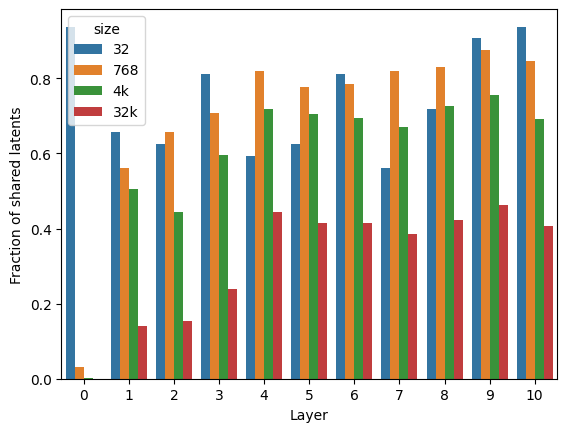

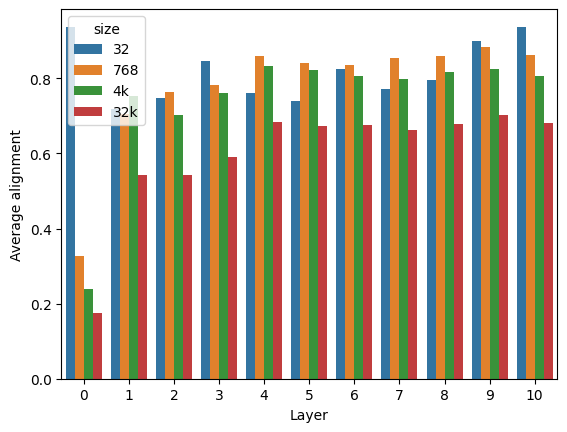

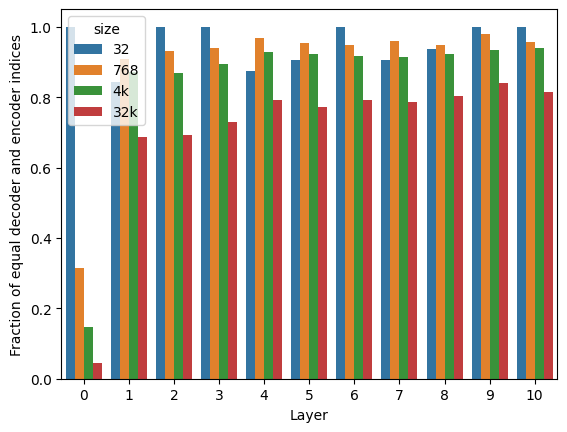

In [23]:
sns.barplot(data=data,x="layer",y="threshold",hue="size")
plt.ylabel("Fraction of shared latents")
plt.xlabel("Layer")
plt.figure()
sns.barplot(data=data,x="layer",y="average_aligment",hue="size")
plt.ylabel("Average alignment")
plt.xlabel("Layer")
plt.figure()
sns.barplot(data=data,x="layer",y="equal",hue="size")
plt.ylabel("Fraction of equal decoder and encoder indices")
plt.xlabel("Layer")

